# data
- raw sequence data가 다음과 같이 주어졌다고 가정

In [1]:
import torch

txt = list("hi!hi?")*10
map_dict = {'!':0, '?':1, 'h':2, 'i':3} 
txt[:10]

['h', 'i', '!', 'h', 'i', '?', 'h', 'i', '!', 'h']

# Preprocessing
- cleaning,tokenization(cleaning할 요소 없음,캐릭터 단위 모델링이므로 토큰화도 없음.둘 다 스킵)
- vectorization


## vectorization
- 여러가지 방법이 있으나(tf-idf,dense vector,one-hot encoding 등등...) 여기서는 원핫인코딩 사용

In [2]:
def mapping(txt,map_dict):
    return [map_dict[chr]for chr in txt]
txt_mapped = mapping(txt,map_dict)
print(txt_mapped[:10])

def onehot_encoding(txt_mapped):
    seq_encoded = torch.nn.functional.one_hot(torch.tensor(txt_mapped))
    return seq_encoded.float()
sequence_data_encoded = onehot_encoding(txt_mapped)
print(sequence_data_encoded[:10])

[2, 3, 0, 2, 3, 1, 2, 3, 0, 2]
tensor([[0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.]])


데이터 살짝 변형<br>
하나의 긴 sequence data를 RNN의 입력으로 해도 되지만 처리속도,성능을 고려했을 때 자그마한 sequencedata로 분리하여 입력해주는게 더 좋은 방법임. 분리하는 방법도 여러가지가 있을 수 있겠는데 여기서는 다음과 같이 분리함<br><br>
raw sequence data : hi?hi!hi?hi!hi?hi! ...........<br>
sequence1 : (x,y) = (hi?,h)<br>
sequence2 : (x,y) = (i?h,i)<br>
sequence3 : (x,y) = (?hi,!)<br>
...<br>

In [3]:
def create_seqdataset(seq_data,seq_length):
    #x = seq_data[:-1]
    #y = seq_data[1:]
    seqs_x = []
    seqs_y = []
    for idx in range(0,len(seq_data)-seq_length):
        seqs_x.append(seq_data[idx:idx+seq_length])
        seqs_y.append(seq_data[idx+seq_length])
    return torch.stack(seqs_x),torch.stack(seqs_y)
    #return seq_x,seq_y

x_data,y_data = create_seqdataset(sequence_data_encoded,3)
print(x_data.shape,y_data.shape)

torch.Size([57, 3, 4]) torch.Size([57, 4])


### 왜 저런 shape을 맞춰 주는가?
여기서 나오는 x_data.shape = $(57,3,4)$가 살짝 난해함. <br>
파이토치 공식문서에 따르면 batch_first = True로 설정할 경우,rnn계열의 모델에 넣어줘야 하는 텐서의 shape은 $(N,L,H_{in})$ = (batch size,sequnce length,input_size)이고 dataloader라는 일종의 데이터 중간관리자?를 한 번 거쳐서 모델에 입력됨. 
dataloader에서 나오는 output.shape = $(N,L,H_{in})$이 되기 위해서는 input.shape = $(D,L,H_{in}$(D는 분리된 시퀀스의 갯수)이어야 함(즉 입력텐서의 차원이 3개여야 출력텐서의 차원도3개이고 차원이 나오는 순서도 저런식이 되어야 함). 따라서 저렇게 설정함.<br><br>

### 파라미터 잠깐 설명 
batch size는 배치의 총 갯수(배치안에 있는 원소의 갯수 아님!), sequnce length는 시퀀스데이터의 길이이자 timestemp(시점)의 총 갯수(길이), $H_{in}$은 each timestep(각 시점)마다 입력되는 벡터의 길이라고 볼 수 있음. 위처럼 원핫인코딩을 한 경우 $H_{in}$은 시퀀스데이터에 있는 문자의 갯수로 결정되므로 4이고 L은 create_seqdataset함수에서 인수로 넣어준 3(sequnce_length)이고 마지막으로 N(batch_size)은 torch.utils.data.DataLoader안에 인수로 넣어주는 batch_size로 인해서 일정한 갯수로 배치를 나누었을때 나오는 배치들의 총 숫자임.rnn 문서에서 설명하는 batch_size는 torch.utils.dada.DataLoader에서 설정한 batch_size의 갯수만큼 데이터를 모아서 여러개의 배치로 만들었을때 나오는 배치의 총 갯수라고 보면됨.(헷갈리는 부분....)<br>

# train

## 학습 준비하기
- define architecture,loss,optimizer
- data check

In [4]:
#architecture,loss,optimizer 
torch.manual_seed(2022)
rnn = torch.nn.RNN(4,20,batch_first = True)
linr = torch.nn.Linear(20,4)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(rnn.parameters())+list(linr.parameters()),lr=1e-3)

In [5]:
ds = torch.utils.data.TensorDataset(x_data,y_data)
dl = torch.utils.data.DataLoader(ds,batch_size=8,drop_last=True)

for idx,(x,y) in enumerate(dl):
    if idx ==5:
        break
    print(x.shape,y.shape)

torch.Size([8, 3, 4]) torch.Size([8, 4])
torch.Size([8, 3, 4]) torch.Size([8, 4])
torch.Size([8, 3, 4]) torch.Size([8, 4])
torch.Size([8, 3, 4]) torch.Size([8, 4])
torch.Size([8, 3, 4]) torch.Size([8, 4])


위에서 언급했듯이 데이터로더를 거쳐서 나오는 텐서는 RNN에 바로 입력될 것임.<br>
input.shape = $(N,L,H_{in}) = (8,3,4)$<br>

## 모형학습

In [6]:
for epoch in range(0,101):
    for tr_x,tr_y in dl:
        #1 output
        hidden,hT = rnn(tr_x)
        #print(hidden.shape)
        output = linr(hT[-1])
        #2 loss
        loss = loss_fn(output,tr_y)
        #3 derivative
        loss.backward()
        #4 update & clean
        optimizer.step()
        optimizer.zero_grad()
    if epoch % 10 == 0:
        print(f'epoch : {epoch},loss : {round(loss.tolist(),5)}')

epoch : 0,loss : 1.31779
epoch : 10,loss : 0.69453
epoch : 20,loss : 0.19338
epoch : 30,loss : 0.05891
epoch : 40,loss : 0.02861
epoch : 50,loss : 0.01791
epoch : 60,loss : 0.0126
epoch : 70,loss : 0.00947
epoch : 80,loss : 0.00744
epoch : 90,loss : 0.00602
epoch : 100,loss : 0.00499


pytorch의 rnn을 거쳐서 나오는 output은 두 가지임.<br>
- hidden : 가장 깊이 위치한 히든레이어의 각각의 시점에서의 출력값을 모아놓은 텐서<br>
- hT : 모든 히든레이어에의 마지막 시점(시점T)에서의 출력값을 모아놓은 텐서<br>
- 외우기! 위치 : 가장깊은 <=> 모든 , 시점 : 각각의 <=> 마지막<br>

위와같은 설정에서는 가장 깊이 위치한 히든레이어의 마지막시점에서의 출력값만이 우리는 다음에올 문자열을 예측할 때 필요하므로 hT[-1]을 하여 그 값을 가져옴.

# 결과확인

([<matplotlib.axis.XTick at 0x1e2e192cdf0>,
 [Text(0, 1, '!'), Text(1, 1, '?'), Text(2, 1, 'h'), Text(3, 1, 'i')])

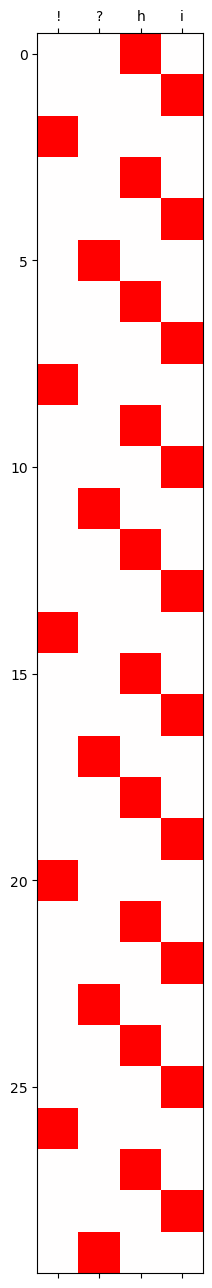

In [7]:
import matplotlib.pyplot as plt
soft = torch.nn.Softmax(dim=1)

hidden,hT = rnn(x_data)
plt.matshow(soft(linr(hT[:,:,:])[0]).data[-30:],cmap="bwr",vmin=-1,vmax=1)
plt.xticks(range(4),labels=map_dict.keys())